bi + ml --> final

In [1]:
import sys
sys.path.append('../../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../../data_lake/output_prod/train_eng.pkl")
val = pd.read_pickle("../../../data_lake/output_prod/val_eng.pkl")

In [4]:
cols = ['card1', 'card2', 'card3','card5','M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38','num_transaction_per_time']

In [5]:
df = df.drop(columns=cols)

In [6]:
val = val.drop(columns=cols)

# 2.0 Machine Learning
## 2.1 Training model

In [7]:
df.sample(1)

,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,num_accounts_related_to_user,num_days_previous_transaction,multi_transaction_per_time,browser_enc,device_info_v4
13206,0,25.0,H,mastercard,debit,299.0,87.0,gmail.com,gmail.com,desktop,1.0,14.833333,0,chrome,windows


In [8]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [9]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [10]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [11]:
parameters = {'model__max_depth':[6,8],'model__n_estimators':[500,800],'model__learning_rate':[0.05,0.1],'model__min_samples_leaf':[3,5]}

In [12]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters,'no')

GridSearchCV results...
Mean Train Scores: 
[0.87795346 0.88916559 0.8819401  0.90386593 0.92143151 0.92504387
 0.91906463 0.92691311 0.9127528  0.9127528  0.90262    0.90262
 0.93820888 0.93820888 0.92907367 0.92907367]

Mean CV Scores: 
[0.82770653 0.8290768  0.82546357 0.83480718 0.83381097 0.83605424
 0.8318177  0.83455799 0.83505655 0.83505655 0.83244046 0.83244046
 0.84228182 0.84228182 0.8363012  0.8363012 ]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



## 2.2 Evaluation model

In [13]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [14]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [15]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8541289933694997
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     19976
         1.0       0.33      0.85      0.48      1659

    accuracy                           0.86     21635
   macro avg       0.66      0.85      0.70     21635
weighted avg       0.94      0.86      0.88     21635

ProductCD: 0.3131138080421156
TransactionAmt: 0.15206507897838095
card4: 0.13282131666567082
P_emaildomain: 0.024525832844155583
addr2: 0.011651621015265292
multi_transaction_per_time: 0.006132504007895845
device_info_v4: 0.005446022434135586
R_emaildomain: 0.0050217864128335446
DeviceType: 0.004105381864471467
num_days_previous_transaction: 0.002238626098770113
num_accounts_related_to_user: 0.001462010765606174
card6: 0.0010347367420872992
addr1: 3.3212425496304924e-05
browser_enc: 2.9153238858545126e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   FunctionTransformer(func=<function log_transform at 0x7f940c5d8670>))]),
                                                  Index(['TransactionAmt', 'num_accounts_re...
                                                                  ('label_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'P_emaildomain',
       'R_emaildomain', 'DeviceType', 'browser_enc', 'device_info_v4'],
      dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(max_depth=8, max_features=1.0,
                                            min_samples_leaf=3,
                                            n_estimators=500,
                                            n_iter_no_change=25, random_state=0,
                                            warm_start=True))])

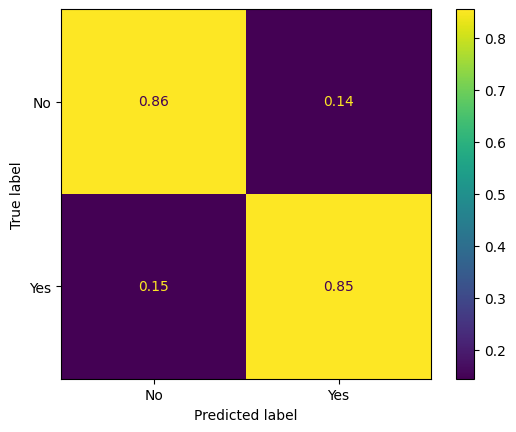

In [16]:
mlu.model_evaluation(m.estimator, X_val, y_val)

# 2.3 Predict probability

In [17]:
val.insert(0,'probability_score','')
val['probability_score'] = model.predict_proba(X_val)[:,1]

# 3.0 Human Knowledge

## 3.1 Traininig HK

In [18]:
df, scaler = mlu.log_beta_scaling(df,'num_accounts_related_to_user','num_days_previous_transaction')

## 3.2 Score HK

In [19]:
val = mlu.log_beta_transform(val,scaler,'num_accounts_related_to_user','num_days_previous_transaction')

In [20]:
val = mlu.warning_score_(val,0.8)

# 4.0 Error analysis

In [21]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,num_accounts_related_to_user,num_days_previous_transaction,multi_transaction_per_time,browser_enc,device_info_v4,warning_score
43444,0.033858,0,50.0,H,mastercard,debit,315.0,87.0,anonymous.com,gmail.com,desktop,1.0,0.0,0,chrome,windows,0.307262
32466,0.047340,0,100.0,R,visa,credit,327.0,87.0,comcast.net,aol.com,mobile,1.0,0.0,0,safari,ios,0.307262


<AxesSubplot: >

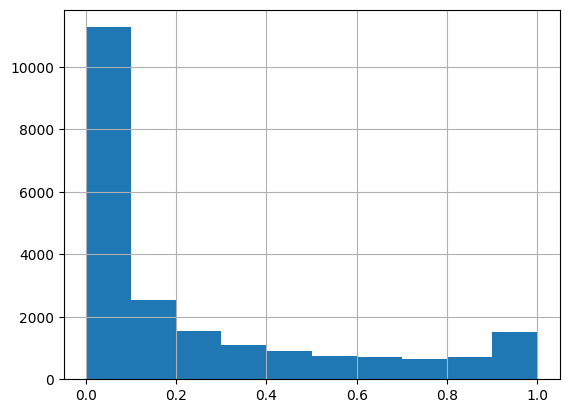

In [22]:
val['probability_score'].hist()

<AxesSubplot: >

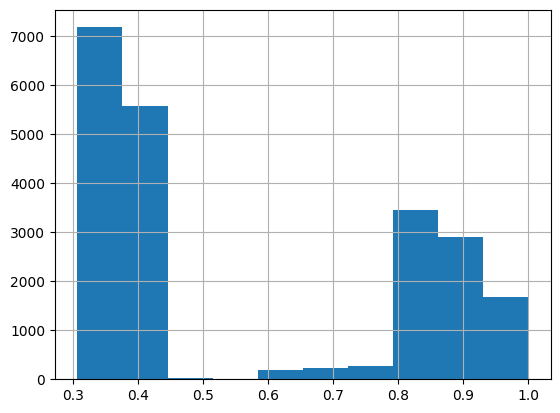

In [23]:
val['warning_score'].hist()

# 5.0 Bayesian Fusion

In [24]:
val['final_score'] = val.apply(lambda x: mlu.beta_fusion(x['probability_score'],x['warning_score'],0.6),axis=1)

In [25]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,num_accounts_related_to_user,num_days_previous_transaction,multi_transaction_per_time,browser_enc,device_info_v4,warning_score,final_score
78473,0.306999,0,44.409,C,visa,credit,nan,nan,gmail.com,gmail.com,mobile,1.0,0.0,0,safari,other,0.332262,0.335394
52948,0.283382,0,21.688,C,visa,debit,nan,nan,outlook.es,outlook.es,desktop,6.0,369.0,0,chrome,windows,0.884159,0.521323


<AxesSubplot: >

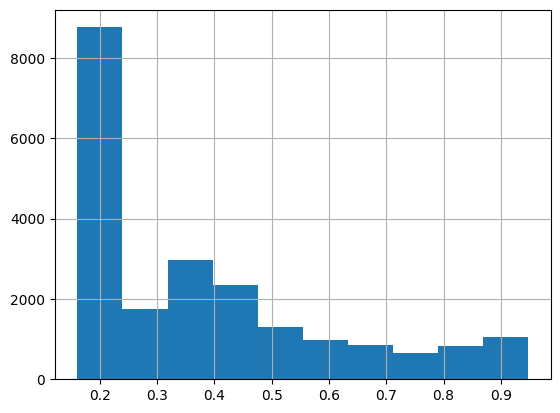

In [26]:
val['final_score'].hist()

# 6.0 Model Output

In [27]:
with open('../../../data_lake/output_prod/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.estimator, file)

In [28]:
with open('../../../data_lake/output_prod/log_scaler_bi.pkl','wb') as file:
    pickle.dump(scaler, file)